# 5. Prioritized Experience Replay
### 這一套算法重點就在我們 batch 抽樣的時候並不是隨機抽樣，而是按照 Memory 中的樣本優先級來抽，這能更有效地找到我們需要學習的樣本。    
### 計算優先順序是使用TD-error，採用目標Q值與當前Q值的差值來表示。TD-error越大，優先級p越高。    
### 每次抽樣都需要針對p對所有樣本排序, 這將會是一件非常消耗計算能力的事，所以用SumTree來做有效抽樣。
參考：https://github.com/rlcode/per    
    
首先，先引入需要的函式庫，設定Episode為500，代表會跑500次遊戲。

In [25]:
import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms

EPISODES = 500

### 此為SumTree物件，用來存priority值。    
要存儲的priority放在樹的葉結點上，也就是最下面一層。    
[圖片來源：https://medium.com/@skywalker0803r/sumtree-algorithm-f150c0f7f0e4]
![title](image/prioritizedReplay01.png)    
    
抽樣時，將root priority除以batch size，分成batch size區間(n=sum(p)/batch_size)，然後在每個區間隨機選取一個數(value)。    
如果root node 的 priority 是42的話, 如果抽6個样本, 這時的區間擁有的 priority 可能是這樣：    
`[0-7], [7-14], [14-21], [21-28], [28-35], [35-42]`    
在區間`[21-28]`選到了24,就按照這個24從最頂上的42開始向下搜索,首先看到最頂上的42下面有兩個child nodes,拿著手中的24對比左邊的child 29,如果左邊的child比自己手中的值大,那就走左邊這條路,接著再對比29下面左邊那個點13這時手中的24比13大,那就走右邊那條路,並且將手中的值根據13修改一下,變成24–13=11,接著拿著11和16左下角的12比,結果12比11大,那就選12當作這次選到的priority,並且也選擇12對應的數據。

In [26]:
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity #葉節點數量
        self.tree = np.zeros(2 * capacity - 1) #總共節點的數量
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [27]:
class Memory:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6
    beta = 0.4
    beta_increment_per_sampling = 0.001

    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.capacity = capacity

    def _get_priority(self, error):
        return (np.abs(error) + self.e) ** self.a

    def add(self, error, sample):
        p = self._get_priority(error)
        self.tree.add(p, sample)

    def sample(self, n):
        batch = []
        idxs = []
        segment = self.tree.total() / n
        priorities = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)
            while True:
                s = random.uniform(a, b)
                (idx, p, data) = self.tree.get(s)
                if not isinstance(data, int):
                    break
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)


        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)

In [28]:
# approximate Q function using Neural Network
# state is input and Q Value of each action is output of network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, action_size)
        )

    def forward(self, x):
        return self.fc(x)

與環境互動的Agent物件。    
在`__init__`中做變數設定，如learning_rate, epsilon, batch_size等。

In [29]:
# DQN Agent for the Cartpole
# it uses Neural Network to approximate q function
# and prioritized experience replay memory & target q network
class DQNAgent():
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.memory_size = 20000
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.explore_step = 5000
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / self.explore_step
        self.batch_size = 64
        self.train_start = 1000

        # create prioritized replay memory using SumTree
        self.memory = Memory(self.memory_size)

        # create main model and target model
        self.model = DQN(state_size, action_size)
        self.model.apply(self.weights_init)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(),
                                    lr=self.learning_rate)

        # initialize target model
        self.update_target_model()

        if self.load_model:
            self.model = torch.load('save_model/cartpole_dqn')

    # weight xavier initialize
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            torch.nn.init.xavier_uniform(m.weight)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.from_numpy(state)
            state = Variable(state).float().cpu()
            q_value = self.model(state)
            _, action = torch.max(q_value, 1)
            return int(action)

    # save sample (error,<s,a,r,s'>) to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        target = self.model(Variable(torch.FloatTensor(state))).data
        old_val = target[0][action]
        target_val = self.target_model(Variable(torch.FloatTensor(next_state))).data
        if done:
            target[0][action] = reward
        else:
            target[0][action] = reward + self.discount_factor * torch.max(target_val)

        error = abs(old_val - target[0][action])

        self.memory.add(error, (state, action, reward, next_state, done))

    # pick samples from prioritized replay memory (with batch_size)
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay

        mini_batch, idxs, is_weights = self.memory.sample(self.batch_size)
        mini_batch = np.array(mini_batch).transpose()

        states = np.vstack(mini_batch[0])
        actions = list(mini_batch[1])
        rewards = list(mini_batch[2])
        next_states = np.vstack(mini_batch[3])
        dones = mini_batch[4]

        # bool to binary
        dones = dones.astype(int)

        # Q function of current state
        states = torch.Tensor(states)
        states = Variable(states).float()
        pred = self.model(states)

        # one-hot encoding
        a = torch.LongTensor(actions).view(-1, 1)

        one_hot_action = torch.FloatTensor(self.batch_size, self.action_size).zero_()
        one_hot_action.scatter_(1, a, 1)

        pred = torch.sum(pred.mul(Variable(one_hot_action)), dim=1)

        # Q function of next state
        next_states = torch.Tensor(next_states)
        next_states = Variable(next_states).float()
        next_pred = self.target_model(next_states).data

        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        # Q Learning: get maximum Q value at s' from target model
        target = rewards + (1 - dones) * self.discount_factor * next_pred.max(1)[0]
        target = Variable(target)

        errors = torch.abs(pred - target).data.numpy()

        # update priority
        for i in range(self.batch_size):
            idx = idxs[i]
            self.memory.update(idx, errors[i])

        self.optimizer.zero_grad()

        # MSE Loss function
        loss = (torch.FloatTensor(is_weights) * F.mse_loss(pred, target)).mean()
        loss.backward()

        # and train
        self.optimizer.step()

### Main Function
環境為CartPole-v1，會跑500個episode，如果最近十筆資料的score都大於490分，則會提前終止。    

/Users/patty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


episode: 0   score: 16.0   memory length: 17   epsilon: 1.0
episode: 1   score: 15.0   memory length: 33   epsilon: 1.0
episode: 2   score: 23.0   memory length: 57   epsilon: 1.0
episode: 3   score: 11.0   memory length: 69   epsilon: 1.0
episode: 4   score: 13.0   memory length: 83   epsilon: 1.0
episode: 5   score: 21.0   memory length: 105   epsilon: 1.0
episode: 6   score: 35.0   memory length: 141   epsilon: 1.0
episode: 7   score: 17.0   memory length: 159   epsilon: 1.0
episode: 8   score: 9.0   memory length: 169   epsilon: 1.0
episode: 9   score: 10.0   memory length: 180   epsilon: 1.0
episode: 10   score: 10.0   memory length: 191   epsilon: 1.0
episode: 11   score: 52.0   memory length: 244   epsilon: 1.0
episode: 12   score: 53.0   memory length: 298   epsilon: 1.0
episode: 13   score: 13.0   memory length: 312   epsilon: 1.0
episode: 14   score: 16.0   memory length: 329   epsilon: 1.0
episode: 15   score: 12.0   memory length: 342   epsilon: 1.0
episode: 16   score: 49.

SystemExit: 

/Users/patty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3333: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


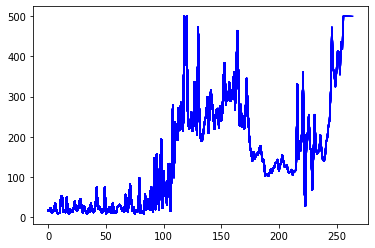

In [32]:
# In case of CartPole-v1, maximum length of episode is 500
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
model = DQN(state_size, action_size)

agent = DQNAgent(state_size, action_size)
scores, episodes = [], []

for e in range(EPISODES):
    done = False
    score = 0

    state = env.reset()
    state = np.reshape(state, [1, state_size])

    while not done:
        if agent.render:
            env.render()

        # get action for the current state and go one step in environment
        action = agent.get_action(state)

        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100
        reward = reward if not done or score == 499 else -10

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
        # every time step do the training
        if agent.memory.tree.n_entries >= agent.train_start:
            agent.train_model()

        score += reward
        state = next_state

        if done:
            # every episode update the target model to be same with model
            agent.update_target_model()

            # every episode, plot the play time
            score = score if score == 500 else score + 10
            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')
            pylab.savefig("./image/cartpole_dqn.png")
            print("episode:", e, "  score:", score, "  memory length:",
                  agent.memory.tree.n_entries, "  epsilon:", agent.epsilon)

            # if the mean of scores of last 10 episode is bigger than 490
            # stop training
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                #torch.save(agent.model, "./save_model/cartpole_dqn")
                sys.exit()